# Technology Fundamentals, Course 3 Enrichment 1: Support Vector Machines and Boosting

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

**Teaching Assitants**: Varsha Bang, Harsha Vardhan

**Contact**: vbang@uw.edu, harshav@uw.edu
<br>

---

<br>

In this session, we're continuing on the topic of supervised learning models with Support Vector Machines or SVMs.

<br>

---

<br>

<a name='top'></a>

# Contents

* 5.0 [Preparing Environment and Importing Data](#x.0)
  * 5.0.1 [Import Packages](#x.0.1)
  * 5.0.2 [Load Dataset](#x.0.2)
* 5.1 [Support Vector Machines](#x.1)
  * 5.1.1 [Margin Maximization](#x.1.1)
  * 5.1.2 [Kernel SVM](#x.1.2)
  * 5.1.3 [Tuning SVMs](#x.1.3)
* 5.2 [Boosting](#x.2)
  * 5.2.1 [AdaBoost](#x.2.1)

<br>

---

<a name='x.0'></a>

## 5.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 5.0.1 Import Packages

[back to top](#top)

In [ ]:
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from ipywidgets import interact, FloatSlider, interactive

<a name='x.0.2'></a>

### 5.0.2 Load Dataset

[back to top](#top)

For this session, we will use dummy datasets from sklearn.

<a name='x.1'></a>

## 5.1 Support Vector Machines

[back to top](#top)

I want us to think back on Session 3 during our discussion on GMMs. GMMs, we will remember, are what we call a *generative* method. It is because of this, that GMMs are able to generate new data based on the underlying distribution it assumes. SVMs, on the other hand, are a *discriminative* model. It's perogative is to find the best way to delineate between data clusters. It does this by concerning itself with *margin*, something we will explore in the following cells.

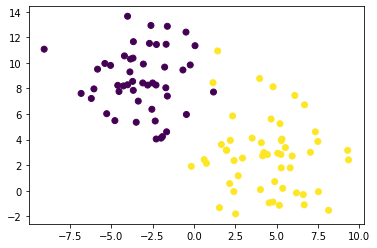

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42, centers=2, cluster_std=2.5)
y[25] = 1
y[33] = 1
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

We can also view this with an interactive plotly graph:

In [ ]:
# making the data labels
labels = []
i = 0
for row in X:
  labels.append("X: {}\nindex: {}".format(np.array2string(row.round()),i))
  i += 1

# the scatter plot
fig = px.scatter(x=X[:,0], y=X[:,1], hover_name=labels, color=y,
                 labels={
                     "y": "Feat 1",
                     "x": "Feat 2",
                     "color": "Label",
                 })
# updating fig attributes
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='A Smattering of Points with Outlier (index 45)'
  )

In [ ]:
clf = svm.SVC(kernel='linear', C=.01)
clf.fit(X, y)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
def plot_boundaries(X, clf, ax=False):
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  
  if ax:
    cs = ax.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='grey', alpha=0.9)
    return ax
  else:
    cs = plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='grey', alpha=0.9)
  

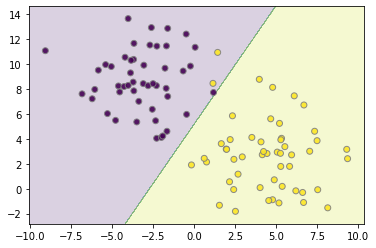

In [ ]:
plot_boundaries(X, clf)

<a name='x.1.1'></a>

### 5.1.1 Margin Maximization

[back to top](#top)

We can change how the learner defines the boarders by the 'C' parameter, what is happening here?

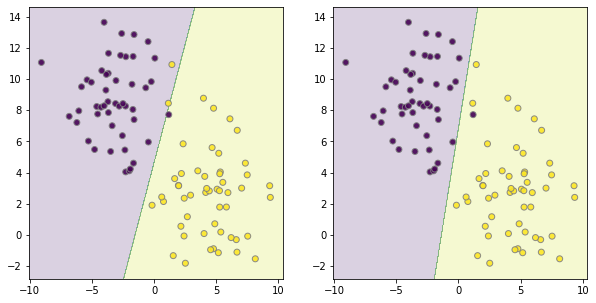

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
clf = svm.SVC(kernel='linear', C=.05)
clf.fit(X, y)
plot_boundaries(X, clf, ax[0])

clf = svm.SVC(kernel='linear', C=1)
clf.fit(X, y)
plot_boundaries(X, clf, ax[1])

We can see more clearly what is happening when we view the *margin* around the decision boundary, where point labels are used to determine the label space.

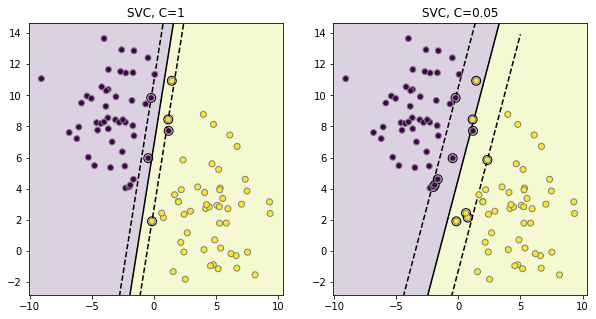

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
def plot_svm(penalty, subplot, X, y):
  clf = svm.SVC(kernel='linear', C=penalty)
  clf.fit(X, y)

  # get the separating hyperplane
  w = clf.coef_[0]
  a = -w[0] / w[1]
  xx = np.linspace(-5, 5)
  yy = a * xx - (clf.intercept_[0]) / w[1]

  # plot the parallels to the separating hyperplane that pass through the
  # support vectors (margin away from hyperplane in direction
  # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
  # 2-d.
  margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
  yy_down = yy - np.sqrt(1 + a ** 2) * margin
  yy_up = yy + np.sqrt(1 + a ** 2) * margin

  # plot the line, the points, and the nearest vectors to the plane
  # plt.clf()
  subplot.plot(xx, yy, 'k-')
  subplot.plot(xx, yy_down, 'k--')
  subplot.plot(xx, yy_up, 'k--')

  subplot.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
              facecolors='none', zorder=10, edgecolors='k')
  subplot.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap='viridis',
              edgecolors='grey')

  subplot.axis('tight')
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  cs = subplot.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)

  subplot.set_xlim(x_min, x_max)
  subplot.set_ylim(y_min, y_max)
  subplot.set_title('SVC, C={}'.format(penalty))

for penalty, subplot in ((1, ax[0]), (0.05, ax[1])):
  plot_svm(penalty, subplot, X, y)
    

plt.show()

In the above diagrams, the circled datapoints affect the *margin* between the two class labels. The SVM algorithm is trying to maximize the margin. The dotted lines are called the *support vectors* and are defined by the outermost points from the decision boundary that fall within the margin.

Effectively, the higher we set the penalty, C, the more we are saying "Don't trust the overall distribution so much, just do your best to segment the local points. A lower C takes into account many more points in the sampled data near the boundary.

> Do the points falling outside either of the support vectors affect the decision boundary?

In [ ]:
def changing_margins(penalty=0.1):
  fig, subplot = plt.subplots(1, 1, figsize=(7,7))
  plot_svm(penalty, subplot, X, y)
  fig.show()

In [ ]:
myslider = FloatSlider(
    value=0.1,
    min=0.1,
    max=3.01,
    step=0.1,
    description='C:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
)

At C=0.1 5 purple and 5 yellow points fall within the decision margin, and are taken into consideration when setting the decision boundary. At C=3.0 this decreases to the nearest 2 purple and 3 yellow. 

In [ ]:
int_plot = interactive(changing_margins,penalty=myslider)
output = int_plot.children[-1]
output.layout.height = '350px'
int_plot

interactive(children=(FloatSlider(value=0.1, description='C:', max=3.01, min=0.1), Output(layout=Layout(height…

<a name='x.1.2'></a>

### 5.1.2 Kernel SVM

[back to top](#top)

When we were looking at KNN and GMM, we saw that GMM had the added advantage of non-linear decision boundaries. We can achieve a similar advantage with kernel based SVMs.

First, I want us to revisit some ideas from the session on feature engineering.

How do we leverage linear based classifiers with non-linear real boundaries between clusters? We create new features.

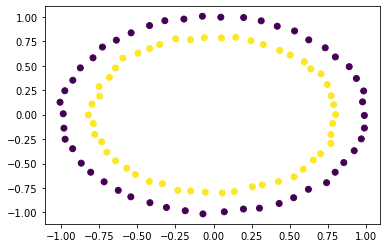

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(random_state=42, noise=.01)
relabel = dict(zip([0,1,2,3],[0,1,0,1]))
y = np.vectorize(relabel.get)(y)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

We run into hardtimes with the raw linear SVM:

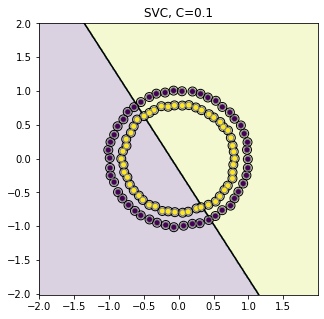

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_svm(penalty=0.1, subplot=ax, X=X, y=y)

#### 5.1.2.1 Exercise: Engineer Features for Linear SVM

Create a new X3 feature that is a linear combination of X1 and X2. Separate this new represenation using Linear SVM

In [ ]:
# Code Cell for Exercise 5.1.2.1

Plot along this 3rd dimension, to show we can make an easy distinction between the two classes with a linear hyperplane:

In [ ]:
# Code Cell for Exercise 5.1.2.1

But the guesswork involved in what features to engineer, as well as the computational cost to determine them, can be a real deal breaker. Kernel SVMs introduce the so-called *kernel trick*, where we learn the classification in a higher-dimensional space without actually computing the representation. Instead, it works by directly computing the distance of the datapoints in the new space.

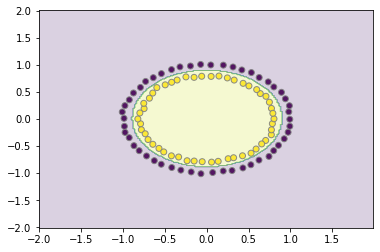

In [ ]:
clf = svm.SVC(kernel='rbf', C=0.1)
clf.fit(X, y)
plot_boundaries(X, clf)

<a name='x.2'></a>

## 5.2 Boosting

[back to top](#top)

The last supervised learning algorithms we will cover, are the boosting learners. Similar to Bagging, Boosting algorithms leverage the idea of training on variations of the available data, only this time they do so in serial rather than parallel.

What do I mean by this?

It's a little nuanced, but the idea is straight forward. The first model trains on the dataset, it generates some error. The datapoints creating the greatest amount of error are emphasized in the second round of training, and so on, as the sequence of models proceeds, ever troublesome datapoints receive ever increasing influence. 



<a name='x.2.1'></a>

### 5.2.1 AdaBoost

[Back to Top](#top)

AdaBoost is the first boosting learner. It's _weak learners_ the things that are stitched together in serial, are typically _stumps_ or really shallow decision trees

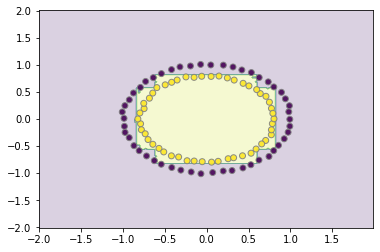

In [ ]:
X, y = make_circles(random_state=42, noise=.01)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
clf.fit(X,y)
plot_boundaries(X, clf)

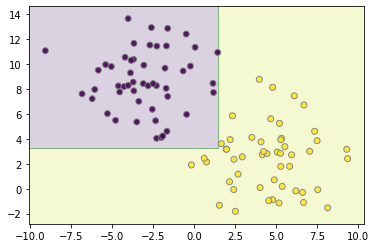

In [ ]:
X, y = make_blobs(random_state=42, centers=2, cluster_std=2.5)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5))
clf.fit(X,y)
plot_boundaries(X, clf)

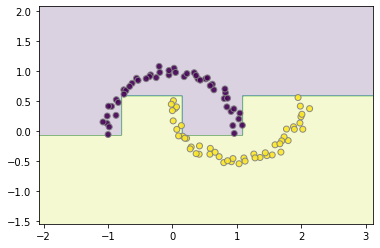

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(random_state=42, noise=.05)
clf = AdaBoostClassifier()
clf.fit(X,y)
plot_boundaries(X, clf)

<a name='x.2.1'></a>

### 5.2.1 Gradient Boosting

[Back to Top](#top)

_Gradient Boosting_ builds on the idea of _AdaBoost_. The term _gradient_ implies that 2 or more derivatives are being taken somewhere. What this is referring to, is while AdaBoost is subject to a predefined loss function, Gradient Boosting can take in any arbitrary (as long as it is differentiable) loss function, to coordinate the training of its weak learners.

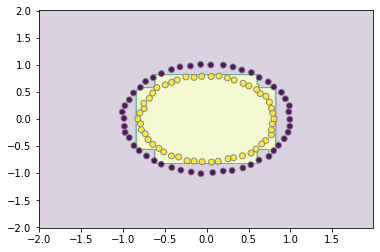

In [ ]:
X, y = make_circles(random_state=42, noise=.01)
clf = GradientBoostingClassifier(loss='deviance')
clf.fit(X,y)
plot_boundaries(X, clf)

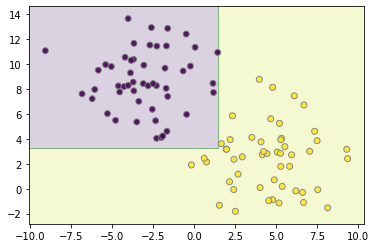

In [ ]:
X, y = make_blobs(random_state=42, centers=2, cluster_std=2.5)
clf = GradientBoostingClassifier()
clf.fit(X,y)
plot_boundaries(X, clf)

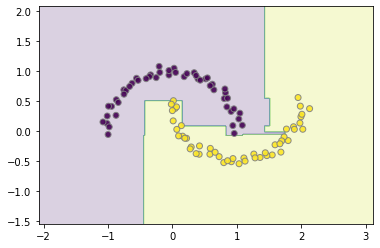

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(random_state=42, noise=.05)
clf.fit(X,y)
plot_boundaries(X, clf)

# References

[back to top](#top)

* [Generative vs Discriminative Models](https://medium.com/swlh/machine-learning-generative-vs-discriminative-models-9d0fdd156296#:~:text=Commonly%20used%20discriminative%20learning%20algorithms,random%20forest%20and%20gradient%20boosting.&text=The%20most%20commonly%20used%20generative%20algorithm%20is%20the%20naive%20Bayes%20classifier.)